# Práctica 5: Redes en un Mapa

Por Eduardo Graells-Garrido (Barcelona Supercomputing Center, <eduardo.graells@bsc.es>).

En este notebook exploraremos los viajes de la Encuesta Origen-Destino 2012 de Santiago utilizando visualizaciones de redes.

### Preámbulo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd

from aves.data import DATA_PATH
from aves.data import eod, census
from aves.features.utils import normalize_rows

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# esto configura la apariencia de los gráficos: tamaños de letra, bordes, colores base, etc.
sns.set(context='paper', font='Fira Code', style='ticks', palette='colorblind', font_scale=1.1)

In [3]:
comunas = census.read_census_map('comuna')

In [4]:
zones = gpd.read_file(DATA_PATH / 'processed/scl_zonas_urbanas.json').set_index('ID')
zones.head()

,AREA,Zona,Com,Comuna,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,NOM_COMUNA,URBANO,TIPO,NOM_CATEG,SHAPE_Leng,SHAPE_Area,area_m2,geometry
ID,,,,,,,,,,,,,,,,
103,837.7500,103.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,4.575649e+05,"POLYGON ((-70.65497 -33.55493, -70.65492 -33.5..."
104,998.8125,104.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,7.725462e+05,"POLYGON ((-70.67767 -33.55753, -70.67599 -33.5..."
106,286.2500,106.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,2.693839e+06,"POLYGON ((-70.69714 -33.56361, -70.69714 -33.5..."
115,857.4375,115.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,7.534193e+05,"POLYGON ((-70.67602 -33.55525, -70.67625 -33.5..."
116,853.9375,116.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,7.184305e+05,"POLYGON ((-70.66701 -33.55231, -70.66564 -33.5..."


In [5]:
viajes = eod.read_trips()

# descartamos sectores que no sean relevantes en los orígenes y destinos de los viajes
viajes = viajes[(viajes['SectorOrigen'] != 'Exterior a RM') 
                & (viajes['SectorDestino'] != 'Exterior a RM')
                & (viajes['SectorOrigen'] != 'Extensión Sur-Poniente') 
                & (viajes['SectorDestino'] != 'Extensión Sur-Poniente')
                & pd.notnull(viajes['SectorOrigen'])
                & pd.notnull(viajes['SectorDestino'])
                # también descartamos viajes que hayan sido imputados en la encuesta
                & (viajes['Imputada'] == 0)
                # y finalmente descartamos viajes cuya distancia indique que son viajes cortísimos o bien demasiado largos para el tamaño de la ciudad
                & (viajes['DistManhattan'].between(500, 35000))]

print(len(viajes))

77288


In [6]:
personas = eod.read_people()
viajes_persona = viajes.merge(personas)

In [7]:
viajes_persona['PesoLaboral'] = viajes_persona['FactorLaboralNormal'] * viajes_persona['Factor_LaboralNormal']

## ¿Cómo se relacionan las comunas de acuerdo a los viajes entre ellas, por propósito?

Primero, preparemos el `GeoDataFrame` de comunas. Tenemos que quedarnos solo con las comunas que nos interesan, y tenemos que asegurarnos que tenga los mismos nombres que en el `DataFrame` de viajes.

In [8]:
comunas.head()

,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,COMUNA,NOM_COMUNA,SHAPE_Leng,SHAPE_Area,geometry
0,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,1.625330,0.066035,"POLYGON ((-70.61889 -33.73808, -70.61811 -33.7..."
1,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13402,BUIN,0.884164,0.021166,"POLYGON ((-70.63192 -33.64634, -70.63207 -33.6..."
2,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13124,PUDAHUEL,0.720176,0.019124,"POLYGON ((-70.78914 -33.36153, -70.78824 -33.3..."
3,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13103,CERRO NAVIA,0.170180,0.001076,"POLYGON ((-70.71927 -33.41334, -70.71888 -33.4..."
4,13,REGIÓN METROPOLITANA DE SANTIAGO,133,CHACABUCO,13301,COLINA,1.692007,0.093820,"POLYGON ((-70.59630 -32.95138, -70.59673 -32.9..."


Hacemos dos cosas:

- Como tenemos las zonas urbanas, filtramos el `GeoDataFrame` para quedarnos solamente con aquellas comunas que están en el `DataFrame` de zonas.
- Hacemos un diccionario de `código de comuna -> nombre de comuna` a partir de las zonas y lo aplicamos.

<AxesSubplot:>

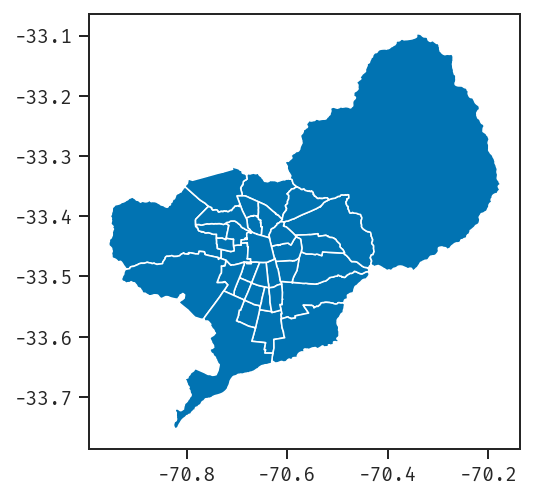

In [9]:
comunas_urbanas = comunas[comunas['COMUNA'].isin(zones['Com'].unique())].drop('NOM_COMUNA', axis=1).copy()
comunas_urbanas['NombreComuna'] = comunas_urbanas['COMUNA'].map(dict(zip(zones['Com'], zones['Comuna'])))
comunas_urbanas.plot()

El mapa es demasiado grande, así que lo recortaremos utilizando las zonas que conocemos:

In [10]:
from aves.features.geo import clip_area_geodataframe

In [11]:
bounding_box = zones.total_bounds
bounding_box

array([-70.88006218, -33.67612715, -70.43015094, -33.31109652])

In [12]:
comunas_urbanas = clip_area_geodataframe(comunas_urbanas, zones.total_bounds, buffer=0.05)

Necesitamos que los nodos tengan un identificador numérico, cuyo valor inicial es cero.

In [13]:
comunas_urbanas['node_id'] = range(len(comunas_urbanas))

In [14]:
comunas_urbanas['node_id']

2      0
3      1
7      2
8      3
11     4
12     5
13     6
14     7
15     8
16     9
18    10
19    11
20    12
21    13
22    14
23    15
24    16
25    17
26    18
27    19
28    20
29    21
31    22
32    23
35    24
36    25
37    26
39    27
42    28
43    29
44    30
45    31
46    32
47    33
Name: node_id, dtype: int64

Calculamos la lista de aristas de nuestra red, es decir, la cantidad de viajes de una comuna a otra. En este caso, lo haremos con los viajes al trabajo.

In [61]:
matriz = (viajes_persona[(viajes_persona['Proposito'] == 'Al trabajo') 
                              & (viajes_persona['ComunaOrigen'].isin(comunas_urbanas['NombreComuna']))
                              & (viajes_persona['ComunaDestino'].isin(comunas_urbanas['NombreComuna']))]
                .groupby(['ComunaOrigen', 'ComunaDestino'])
                .agg(n_viajes=('PesoLaboral', 'sum'))
                .reset_index()
)

matriz.head()

,ComunaOrigen,ComunaDestino,n_viajes
0,Cerrillos,Cerrillos,3661.151331
1,Cerrillos,Conchalí,142.637327
2,Cerrillos,El Bosque,68.819420
3,Cerrillos,Estación Central,635.342831
4,Cerrillos,Independencia,569.960711


Podemos convertir esta lista en una matriz de adyacencia. Veamos como luce esta matriz con el esquema `adjacency_matrix`. Como vimos en clase, utiliza la misma codificación visual que el `heatmap` de tablas, por lo que podemos usar `seaborn.heatmap` para visualizarla:

<AxesSubplot:xlabel='ComunaDestino', ylabel='ComunaOrigen'>

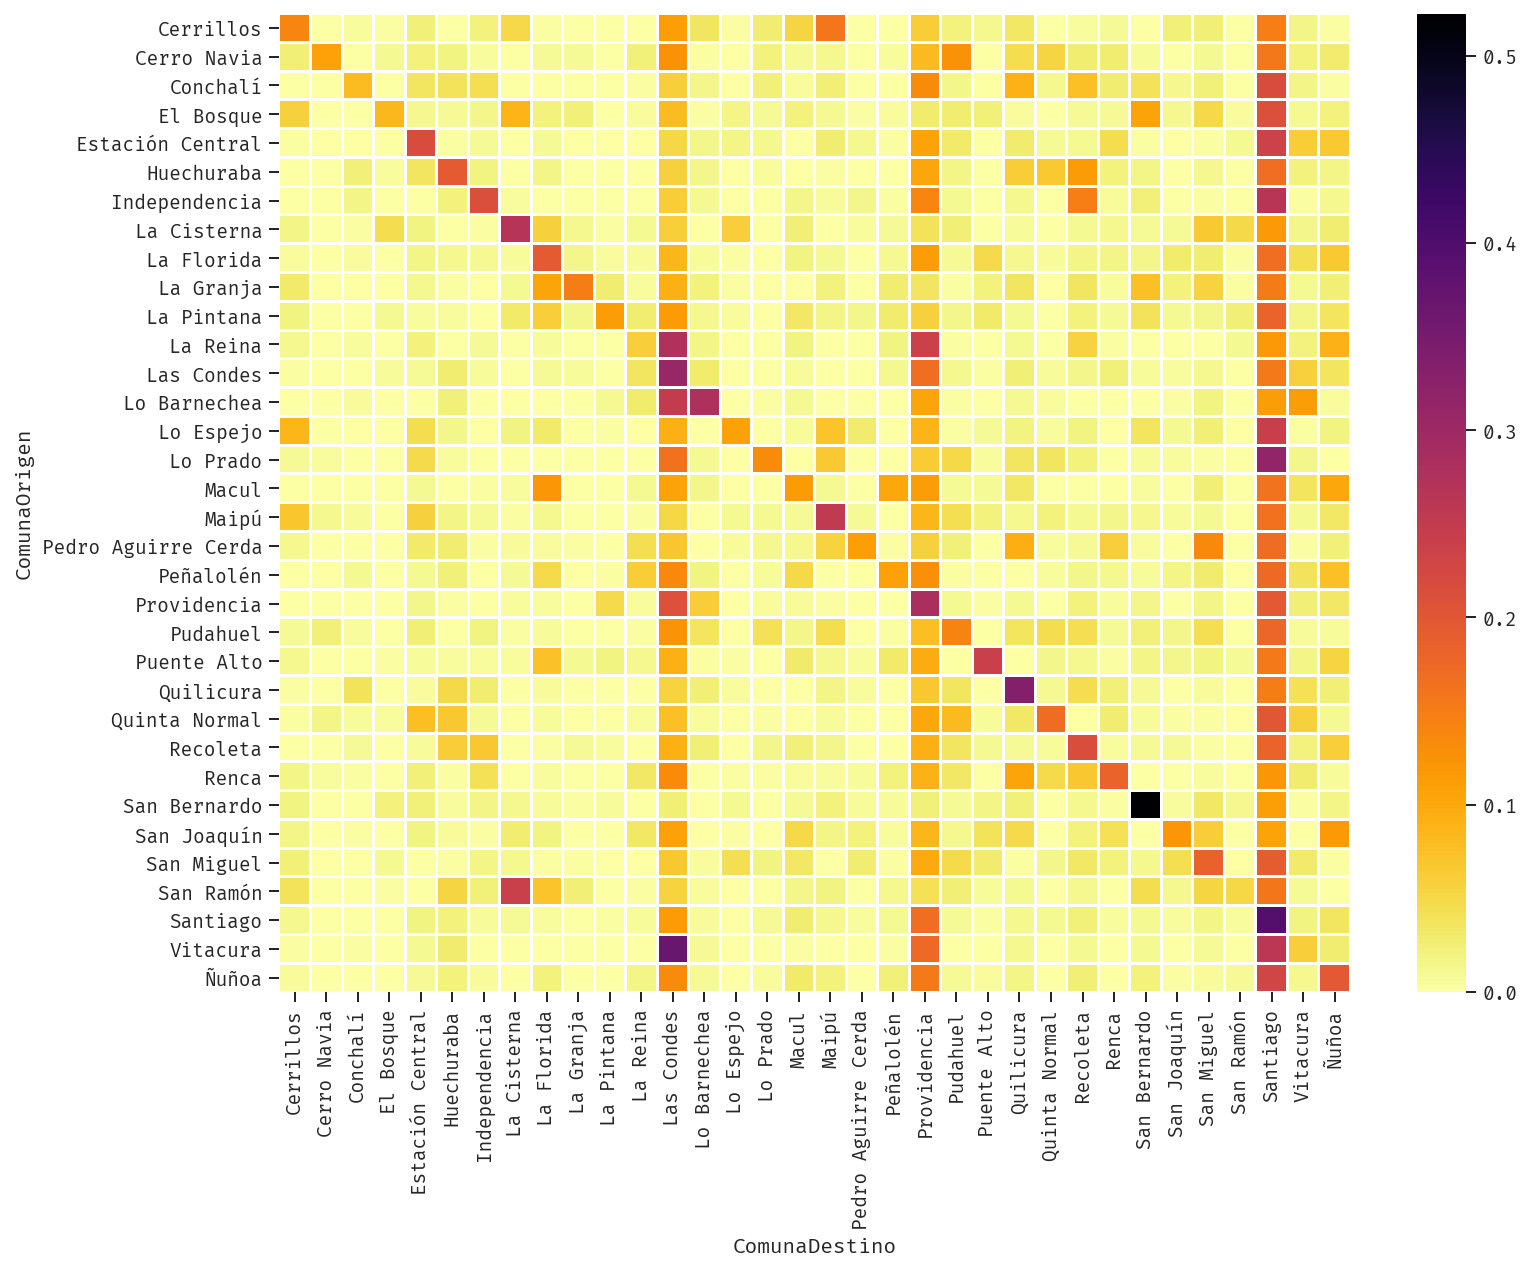

In [62]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(matriz.set_index(['ComunaOrigen', 'ComunaDestino'])['n_viajes'].unstack(fill_value=0).pipe(normalize_rows), cmap='inferno_r', linewidth=1)

Necesitaremos un mapa de `comuna -> nodo` para aplicarlo a la tabla, para que `graph-tool` pueda construir las aristas.

In [57]:
comuna_to_node = dict(zip(comunas_urbanas['NombreComuna'], comunas_urbanas['node_id']))
comuna_to_node

{'Pudahuel': 0,
 'Cerro Navia': 1,
 'Huechuraba': 2,
 'Conchalí': 3,
 'La Pintana': 4,
 'El Bosque': 5,
 'Estación Central': 6,
 'Pedro Aguirre Cerda': 7,
 'Recoleta': 8,
 'Independencia': 9,
 'Lo Espejo': 10,
 'La Cisterna': 11,
 'La Florida': 12,
 'Peñalolén': 13,
 'Las Condes': 14,
 'La Reina': 15,
 'Lo Barnechea': 16,
 'Vitacura': 17,
 'Quinta Normal': 18,
 'Lo Prado': 19,
 'Cerrillos': 20,
 'Maipú': 21,
 'Macul': 22,
 'Ñuñoa': 23,
 'Puente Alto': 24,
 'Quilicura': 25,
 'Renca': 26,
 'San Bernardo': 27,
 'San Joaquín': 28,
 'San Miguel': 29,
 'San Ramón': 30,
 'La Granja': 31,
 'Providencia': 32,
 'Santiago': 33}

In [21]:
from aves.visualization.figures import figure_from_geodataframe

In [22]:
from aves.visualization.maps import GeographicalNodeLink

In [65]:
geonodelink = GeographicalNodeLink.from_edgelist_and_geodataframe(
    matriz[matriz['n_viajes'] > matriz['n_viajes'].quantile(0.75)], 
    comunas_urbanas, 
    # en las aristas
    source='ComunaOrigen', 
    target='ComunaDestino', 
    # en la geografía
    node_column='NombreComuna', 
    # en las aristas
    weight='n_viajes')

{'San Miguel', 'Renca', 'Santiago', 'San Bernardo', 'La Reina', 'Puente Alto', 'Pudahuel', 'Quilicura', 'Quinta Normal', 'Lo Barnechea', 'Providencia', 'Huechuraba', 'Lo Espejo', 'Conchalí', 'Maipú', 'Recoleta', 'San Ramón', 'Cerro Navia', 'Cerrillos', 'Vitacura', 'Pedro Aguirre Cerda', 'La Granja', 'Estación Central', 'San Joaquín', 'Las Condes', 'La Cisterna', 'La Florida', 'La Pintana', 'Ñuñoa', 'Lo Prado', 'Peñalolén', 'Macul', 'Independencia', 'El Bosque'}
node map 34


<class 'str'>


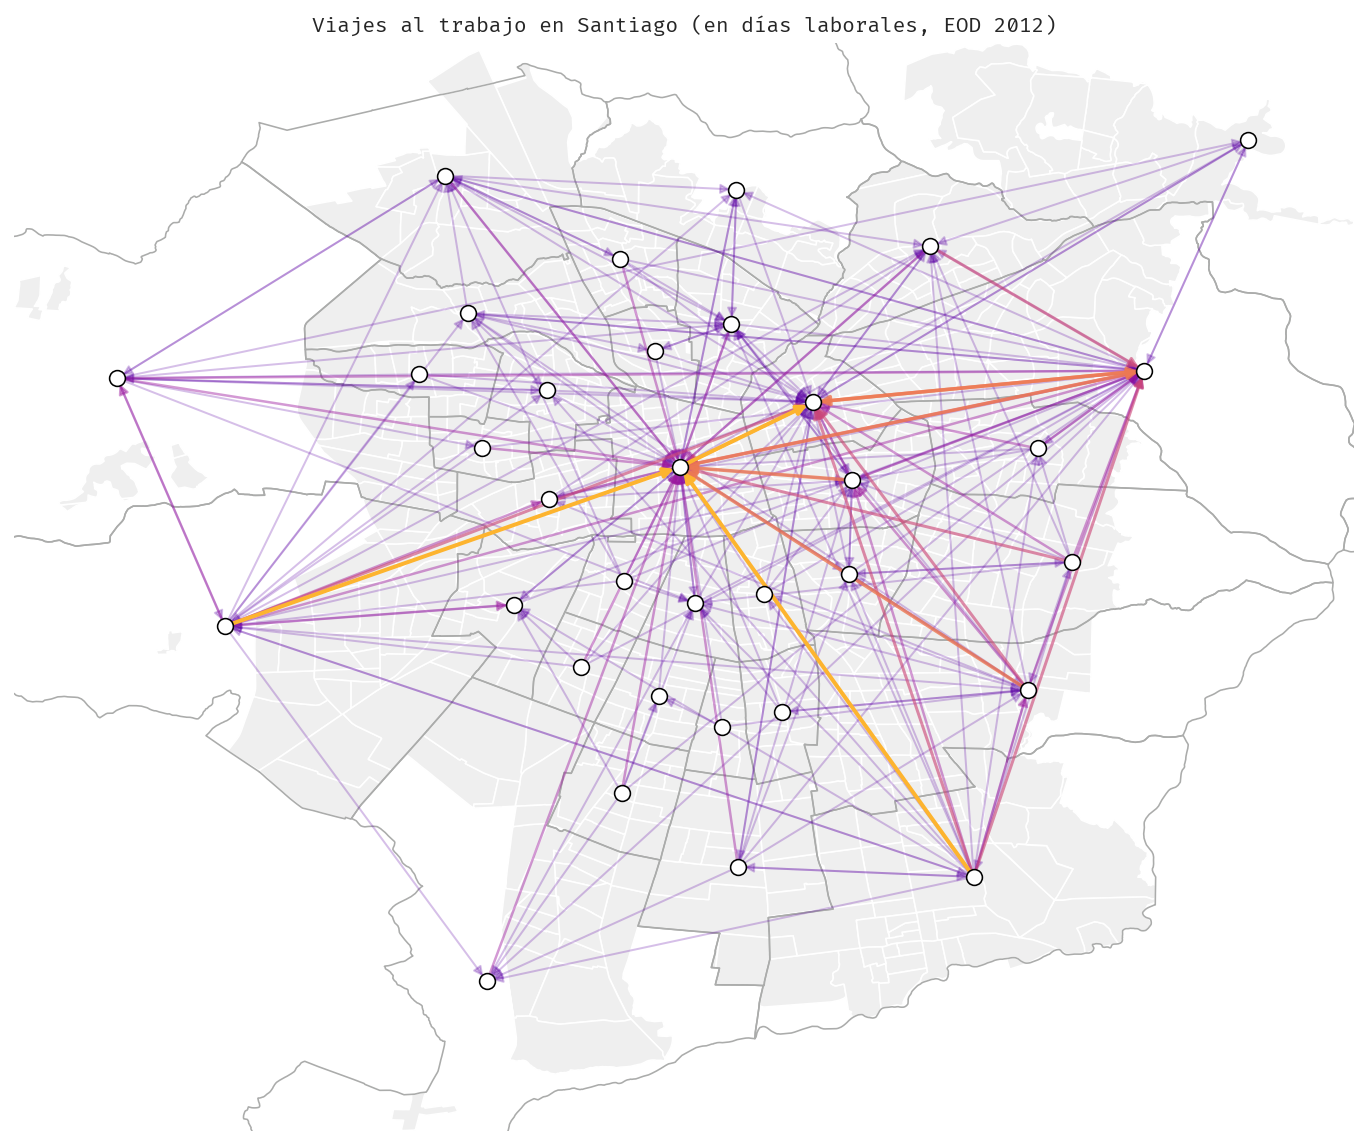

In [70]:
fig, ax = figure_from_geodataframe(zones, height=10, set_limits=True, remove_axes=True)

zones.plot(ax=ax, facecolor='#efefef', edgecolor='white', zorder=0)

comunas_urbanas.plot(ax=ax, facecolor='none', edgecolor='#abacab', zorder=0)

geonodelink.plot_weighted_edges(ax, palette='plasma', log_transform=False, weight_bins=5,
                                min_linewidth=1, linewidth=2, min_alpha=0.25, alpha=1.0,
                                with_arrows=True, arrow_shrink=3, arrow_scale=10, zorder=1)
                    
geonodelink.plot_nodes(ax, color='white', edgecolor='black', size=250, zorder=2)

ax.set_title('Viajes al trabajo en Santiago (en días laborales, EOD 2012)');

¿Qué preguntas surgen al ver esta visualización? Por ej., ¿por qué la gente de Maipú va por motivos de salud a Santiago y no a Estación Central o Cerrillos?¿Por qué desde La Florida van a Providencia? Ahora bien, recuerden que este gráfico **no** muestra los viajes dentro de la misma comuna, por lo que debemos tener cuidado al responder.

### Conclusiones

En comparación con la matriz de adyacencia, en esta visualización además de identificar las relaciones entre comunas podemos apreciar el contexto geográfico. Antes de elegir una de estas dos visualizaciones, debemos considerar lo siguiente:

- ¿Nos interesa conocer la relación geográfica entre orígenes y destinos? Por ej., ¿queremos saber si comunas vecinas se comportan similar?¿Nos interesa la distancia de los viajes? En este caso, `node_link` es una buena solución.
- ¿Necesitamos ver _todas_ las aristas? Si es así, el gráfico de `node_link` podría ser inadecuado, ya que no podemos cambiar la posición de los nodos, ni podemos ver las aristas en las que el origen y destino son iguales. Debemos usar `adjacency_matrix`.